In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
DATA = Path('data')
RAW  = DATA/'raw'
SUBMISSIONS = DATA/'submissions'

In [3]:
train      = pd.read_csv(RAW/'train_jqd04QH.csv', low_memory=False)
test       = pd.read_csv(RAW/'test_GYi4Gz5.csv', low_memory=False)
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)

In [4]:
id_col = 'enrollee_id'
cat_cols = ['city', 'gender', 'relevent_experience', 'enrolled_university', 
            'education_level', 'major_discipline', 'experience', 'company_size', 
            'company_type', 'last_new_job']
num_cols = ['city_development_index', 'training_hours']
target_col = 'target'

In [7]:
%%time
from src.utils import to_cat_codes, apply_cats
to_cat_codes(train, cat_cols)
apply_cats(test, train)
for col in cat_cols:
    train[col] = train[col].cat.codes
    test[col] = test[col].cat.codes

CPU times: user 69.6 ms, sys: 0 ns, total: 69.6 ms
Wall time: 72.7 ms


In [8]:
from lightgbm import LGBMClassifier

In [9]:
model = LGBMClassifier(n_estimators=30)
model.fit(train.drop([id_col, target_col], axis=1), train[target_col])
y_test = model.predict_proba(test.drop(id_col, axis=1))[:,1]

In [10]:
test[target_col] = y_test
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)

In [11]:
submission[target_col].describe()

count    15021.000000
mean         0.132557
std          0.071616
min          0.043419
25%          0.081322
50%          0.102207
75%          0.166309
max          0.583009
Name: target, dtype: float64

In [12]:
submission.to_csv(SUBMISSIONS/'03-lgbm_alldata.csv', index=False)

## Catboost

In [13]:
columns = list(train.drop([id_col, target_col], axis=1))
cat_indices = [i for i, col in enumerate(columns) if col in cat_cols]

In [14]:
from catboost import CatBoostClassifier

In [21]:
model = CatBoostClassifier(iterations=250, eval_metric='AUC')
model.fit(train.drop([id_col, target_col], axis=1), train[target_col],
          cat_features=cat_indices)
y_test = model.predict_proba(test.drop(id_col, axis=1))[:,1]

Learning rate set to 0.131289
0:	total: 21.4ms	remaining: 5.32s
1:	total: 34.5ms	remaining: 4.28s
2:	total: 54.5ms	remaining: 4.49s
3:	total: 118ms	remaining: 7.28s
4:	total: 132ms	remaining: 6.45s
5:	total: 168ms	remaining: 6.84s
6:	total: 183ms	remaining: 6.36s
7:	total: 236ms	remaining: 7.15s
8:	total: 285ms	remaining: 7.63s
9:	total: 312ms	remaining: 7.48s
10:	total: 374ms	remaining: 8.12s
11:	total: 392ms	remaining: 7.78s
12:	total: 437ms	remaining: 7.96s
13:	total: 492ms	remaining: 8.3s
14:	total: 545ms	remaining: 8.54s
15:	total: 607ms	remaining: 8.87s
16:	total: 634ms	remaining: 8.69s
17:	total: 695ms	remaining: 8.95s
18:	total: 757ms	remaining: 9.2s
19:	total: 817ms	remaining: 9.4s
20:	total: 836ms	remaining: 9.11s
21:	total: 893ms	remaining: 9.25s
22:	total: 948ms	remaining: 9.36s
23:	total: 997ms	remaining: 9.39s
24:	total: 1.01s	remaining: 9.14s
25:	total: 1.04s	remaining: 8.98s
26:	total: 1.1s	remaining: 9.07s
27:	total: 1.16s	remaining: 9.23s
28:	total: 1.25s	remaining: 9

In [22]:
test[target_col] = y_test
submission = pd.read_csv(RAW/'sample_submission_sxfcbdx.csv', low_memory=False)
submission = pd.merge(submission[[id_col]], test[[id_col, target_col]], how='left', on=id_col)

In [23]:
submission[target_col].describe()

count    15021.000000
mean         0.130054
std          0.079425
min          0.024847
25%          0.074289
50%          0.101135
75%          0.159420
max          0.678199
Name: target, dtype: float64

In [24]:
submission.to_csv(SUBMISSIONS/'04-catboost_alldata.csv', index=False)

## Feature importance

In [25]:
X_train = train.drop([id_col, target_col], axis=1)
y_train = train[target_col]

In [27]:
y_pred = model.predict_proba(X_train)[:,1]

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_pred)

0.7185407072214121

In [30]:
from catboost import Pool

In [31]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, 
                                      model.get_feature_importance(
                                          Pool(X_train, label=y_train, 
                                               cat_features=cat_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, 
                                inplace=False, na_position='last')

In [32]:
feature_score

,Feature,Score
8,company_size,15.128464
1,city_development_index,13.225232
0,city,10.724164
7,experience,10.046123
10,last_new_job,8.754895
11,training_hours,8.076460
4,enrolled_university,7.009541
9,company_type,7.001064
5,education_level,6.873994
6,major_discipline,5.418725


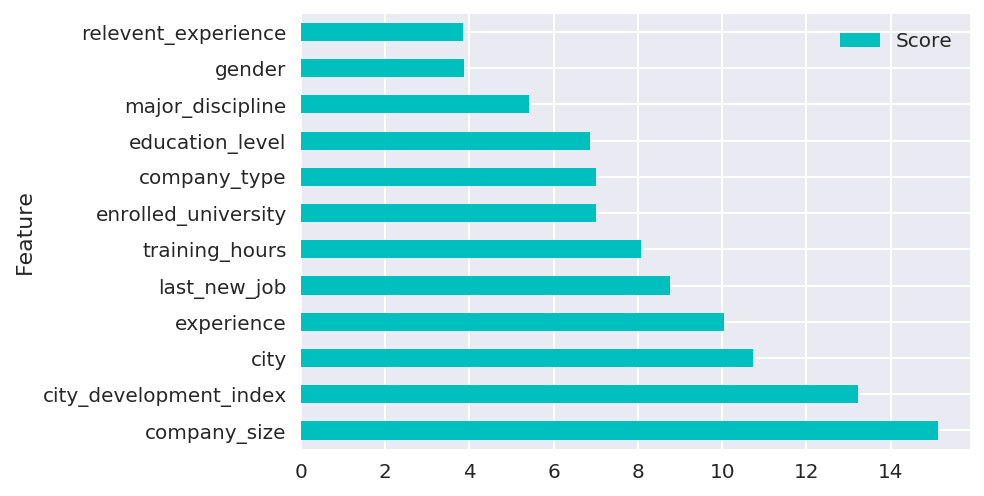

In [35]:
feature_score.plot('Feature', 'Score', kind='barh', color='c')